In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_array, bmat
from scipy.sparse.linalg import splu, spsolve

from resistor_capacitor.src.array import Array
from resistor_capacitor.src.matrix import Matrix
from resistor_capacitor.src.equation import Equation
from resistor_capacitor.src.failure import Failure
from resistor_capacitor.breakdown import breakdown

In [2]:
length = 10
width = 2.0
seed = 0
val_cap = 0.01
time_step = 0.01

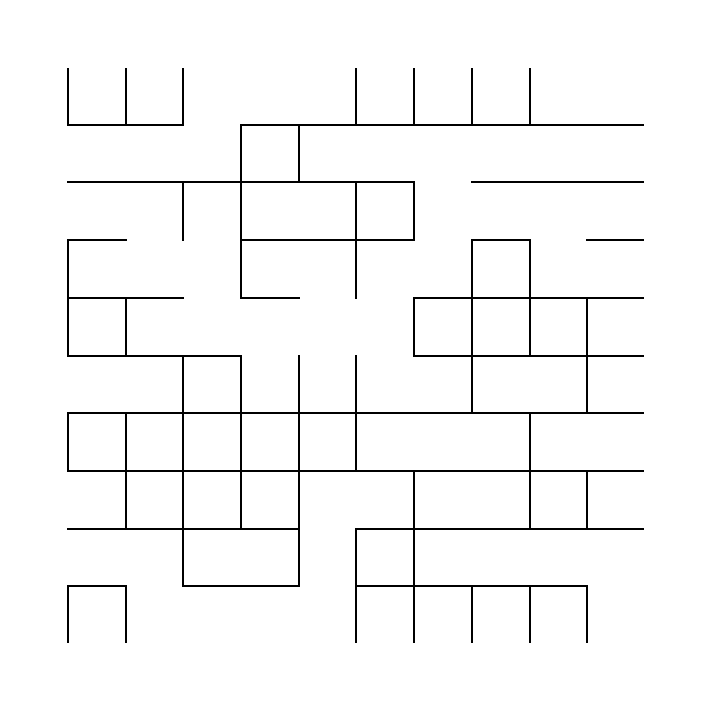

In [3]:
from analysis.rcc_src_tbc.draw import Draw

array, matrix, equation, failure = breakdown(length, width, seed,val_cap, time_step)

draw = Draw(array, matrix, equation, failure)
draw.graph_initialize(
    figsize=(10, 10), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(failure.idxs_edge_broken, 0)

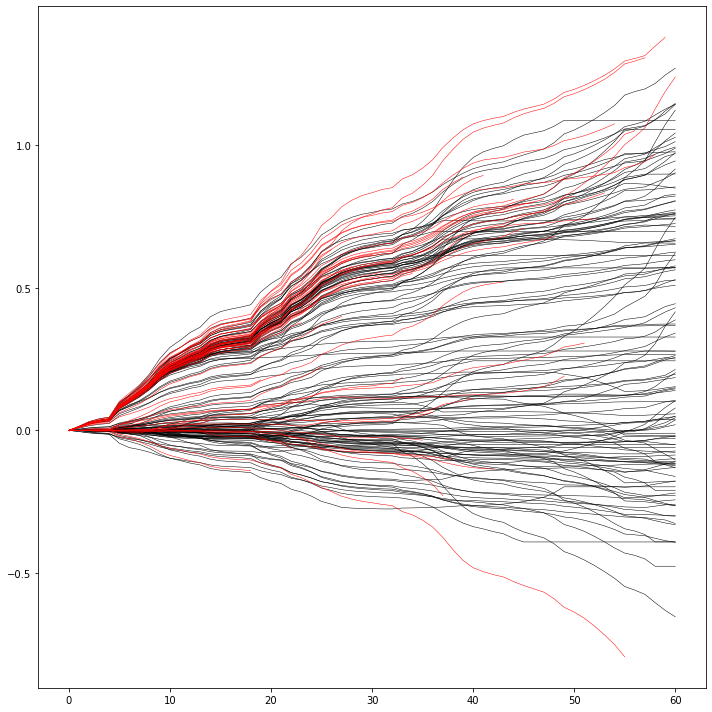

In [4]:
size_obj = 0.5
unsigned = False

profile: np.ndarray = np.array(failure.volts_cap_profile, dtype=np.float64).copy().transpose() # [edge, time]
idxs_edge_broken = failure.idxs_edge_broken
if unsigned: np.abs(profile, out=profile)
num_edge, num_time = profile.shape

for idx_time, idx_edge_broken in enumerate(idxs_edge_broken):
    # if idx_edge_broken is not None:
    profile[idx_edge_broken, (idx_time + 1):] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

#
ax.scatter(0, profile[idxs_edge_broken[0], 0], c="red", s=size_obj, zorder=num_edge)
for idx_edge, votls_per_edge in enumerate(profile):
    if idx_edge in idxs_edge_broken:
        ax.plot(range(num_time), votls_per_edge, c="red", lw=size_obj, zorder=num_edge)
    else:
        ax.plot(range(num_time), votls_per_edge, c="black", lw=size_obj)

#
# ax.set_xlim(20, 40)
# ax.set_ylim(-0.1, 0.25)

plt.tight_layout()
plt.show()


---

In [15]:
array = Array(length=length, mode_analysis=True)
matrix = Matrix(matrix_init=None, array=array, val_cap=val_cap, time_step=time_step)
equation = Equation(array=array, matrix=matrix, save_volts_profile=True)
failure = Failure(array=array, matrix=matrix, equation=equation, width=width, seed=seed, save_volts_profile=True)

In [16]:
# CONSTANT EXTERNAL VOLTAGE (NO SCALING) EXPERIMENT
equation.volt_ext = float(array.length)
failure.idxs_edge_broken_nan = []

def break_edge_experimental(failure: Failure):
    failure._compute_volts_edge()
    stresses_edge_neg = failure.breaking_strengths - failure.volts_edge
    stresses_edge_neg[failure.idxs_edge_broken + failure.idxs_edge_leaf + failure.idxs_edge_island] = np.inf
    idx_edge_broken = failure._find_edge_broken_leaf_proof(stresses_edge_neg)

    if stresses_edge_neg[idx_edge_broken] <= 0:
        # print(0, end=", ") # max is overstressed
        failure._update_matrix(idx_edge_broken)
        failure.idxs_edge_broken.append(idx_edge_broken)
        failure.idxs_edge_broken_nan.append(idx_edge_broken)

    else:
        idx_node1, idx_node2 = failure.array.edges[idx_edge_broken]
        failure.degrees[idx_node1] += 1
        failure.degrees[idx_node2] += 1

        # print(1, end=", ") # all are understressed
        failure.idxs_edge_broken_nan.append(None) # prob have to use dict . or just use time_step counter

    failure._append_volts_edge_profile_dynamic()
    failure._compute_volts_cap_dynamic()
    failure._append_volts_cap_profile_dynamic()
    failure._compute_volts_cond_dynamic()
    failure._append_volts_cond_profile_dynamic()
    failure.volts_ext.append(float(failure.equation.volt_ext))

In [17]:
equation.solve_init()
break_edge_experimental(failure)

In [18]:
solve = equation.solve
solve_r = equation.solve_r_mmd
for _ in range(array.length - 1):
    solve_r()
    solve()
    break_edge_experimental(failure)

In [19]:
solve_r = equation.solve_r_amd
count = 0
while solve_r() and count < 1000:
    solve()
    break_edge_experimental(failure)
    count += 1

In [34]:
size_obj = 0.5
unsigned = False

profile: np.ndarray = np.array(failure.volts_cap_profile, dtype=np.float64).copy().transpose() # [edge, time]
idxs_edge_broken = failure.idxs_edge_broken
if unsigned: np.abs(profile, out=profile)
num_edge, num_time = profile.shape

In [35]:
for idx_time, idx_edge_broken in enumerate(idxs_edge_broken):
    if idx_edge_broken is not None:
        profile[idx_edge_broken, (idx_time + 1):] = np.nan

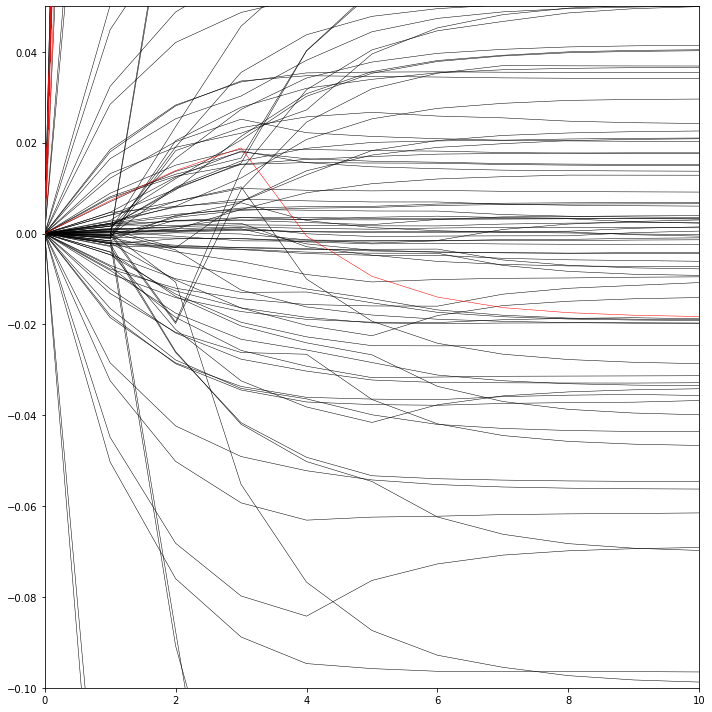

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

#
ax.scatter(0, profile[idxs_edge_broken[0], 0], c="red", s=size_obj, zorder=num_edge)
for idx_edge, votls_per_edge in enumerate(profile):
    if idx_edge in idxs_edge_broken:
        ax.plot(range(num_time), votls_per_edge, c="red", lw=size_obj, zorder=num_edge)
    else:
        ax.plot(range(num_time), votls_per_edge, c="black", lw=size_obj)

#
ax.set_xlim(0, 10)
ax.set_ylim(-0.1, 0.05)

plt.tight_layout()
plt.show()


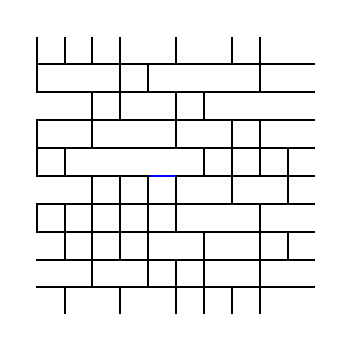

In [32]:
from analysis.rcc_src_tbc.draw import Draw


draw = Draw(array, matrix, equation, failure)
draw.graph_initialize(
    figsize=(5, 5), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(draw.failure.idxs_edge_broken, 1)

-0.026548872360987463


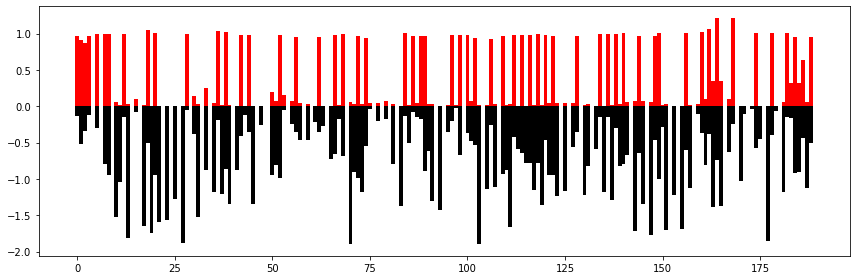

In [37]:
stresses_edge = failure.volts_edge - failure.breaking_strengths
stresses_edge[failure.idxs_edge_broken + failure.idxs_edge_leaf + failure.idxs_edge_island] = np.nan
volts_edge = failure.volts_edge.copy()
volts_edge[failure.idxs_edge_broken + failure.idxs_edge_leaf + failure.idxs_edge_island] = np.nan

print(np.nanmax(stresses_edge))

fig, ax =  plt.subplots(1, 1, figsize=(12, 4), dpi=72)
ax.bar(
    range(array.num_edge),
    volts_edge,
    # range(len(array.idxs_edge_vertical)),
    # volts_edge[array.idxs_edge_vertical],
    width=1, ec="none", color="red",
)
ax.bar(
    range(array.num_edge),
    stresses_edge,
    # range(len(array.idxs_edge_vertical)),
    # stresses_edge[array.idxs_edge_vertical],
    width=1, ec="none", color="black",
)

plt.tight_layout()
plt.show()